# Model development notebook with GPU

## Imports

In [3]:
import pathlib
import random
import model_tools as mt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.utils import shuffle
import scipy.ndimage

random.seed(42)
print('model_tools version:', mt.__version__)
print('tensorflow version: ',tf.__version__)
print('tf datasets version: ', tfds.__version__)
print('matplotlib version:', matplotlib.__version__)
print('numpy version: ', np.__version__)
print('sklearn version:', sklearn.__version__)
print('scipy version:', scipy.__version__)

model_tools version: 1.1.1
tensorflow version:  2.0.0
tf datasets version:  1.2.0
matplotlib version: 3.1.1
numpy version:  1.17.2
sklearn version: 0.22
scipy version: 1.3.1


In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
print("GPU Available: ", tf.test.is_gpu_available())
print("Eager execution enabled: ", tf.executing_eagerly())

GPU Available:  True
Eager execution enabled:  True


## Model building and summary 

In [5]:
models = ['MLP1', 'MLP2', 'lenet5', 'lenet5_tuned', 'simrad', 'simrad_tuned_a', 'simrad_tuned_b']
md={}
for m in models:
    md[m]=mt.build_model(m)
    md[m].summary()

Model: "MLP1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 420)               430500    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               126300    
_________________________________________________________________
output (Dense)               (None, 10)                3010      
Total params: 559,810
Trainable params: 559,810
Non-trainable params: 0
_________________________________________________________________
Model: "MLP2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 1024)              0         
__________________________________________

## Training

In [6]:
# Common
BS=64
EPOCHS=10

In [19]:
# Data prep for MLPs
def prepare_MLP():
    x_train, x_test, x_val, y_train, y_test, y_val = mt.get_mnist(padding=2, categorical=False, flatten=False, y_float=True)
    x_train, y_train = mt.expand_dataset(x_train, y_train, 2, sigma=4.0, alpha=16.0)
    x_train, y_train = shuffle(x_train, y_train)
    return x_train, x_test, x_val, y_train, y_test, y_val
x_train, x_test, x_val, y_train, y_test, y_val = prepare_MLP()

x_train shape:  (48000, 32, 32, 1)
y_train shape:  (48000,)
x_train type:  <class 'numpy.ndarray'>
48000 train samples
10000 test samples
12000 validation samples
{'count': array([4718, 5363, 4792, 4923, 4689, 4346, 4728, 5037, 4660, 4744])}


In [8]:
# Multi Layer Perceptron 1
history_mp1 = md['MLP1'].fit(x_train,y_train, batch_size=BS, epochs=EPOCHS, validation_data=(x_test, y_test))

Train on 144000 samples, validate on 10000 samples
Epoch 1/10
144000/144000 [==============================] - 7s 52us/sample - loss: 0.2258 - accuracy: 0.9301 - val_loss: 0.0788 - val_accuracy: 0.9753
Epoch 2/10
144000/144000 [==============================] - 6s 42us/sample - loss: 0.0886 - accuracy: 0.9724 - val_loss: 0.0555 - val_accuracy: 0.9810
Epoch 3/10
144000/144000 [==============================] - 8s 54us/sample - loss: 0.0579 - accuracy: 0.9812 - val_loss: 0.0536 - val_accuracy: 0.9828
Epoch 4/10
144000/144000 [==============================] - 7s 48us/sample - loss: 0.0426 - accuracy: 0.9861 - val_loss: 0.0482 - val_accuracy: 0.9846
Epoch 5/10
144000/144000 [==============================] - 9s 59us/sample - loss: 0.0309 - accuracy: 0.9901 - val_loss: 0.0448 - val_accuracy: 0.9868
Epoch 6/10
144000/144000 [==============================] - 9s 61us/sample - loss: 0.0241 - accuracy: 0.9919 - val_loss: 0.0547 - val_accuracy: 0.9847
Epoch 7/10
144000/144000 [=================

In [9]:
# Multi Layer Perceptron 2
history_mp2 = md['MLP2'].fit(x_train,y_train, batch_size=BS, epochs=EPOCHS, validation_data=(x_test, y_test))

Train on 144000 samples, validate on 10000 samples
Epoch 1/10
144000/144000 [==============================] - 7s 51us/sample - loss: 0.1746 - accuracy: 0.9463 - val_loss: 0.0742 - val_accuracy: 0.9785
Epoch 2/10
144000/144000 [==============================] - 8s 59us/sample - loss: 0.0788 - accuracy: 0.9769 - val_loss: 0.0639 - val_accuracy: 0.9828
Epoch 3/10
144000/144000 [==============================] - 7s 49us/sample - loss: 0.0617 - accuracy: 0.9824 - val_loss: 0.0794 - val_accuracy: 0.9821
Epoch 4/10
144000/144000 [==============================] - 9s 66us/sample - loss: 0.0540 - accuracy: 0.9853 - val_loss: 0.0700 - val_accuracy: 0.9820
Epoch 5/10
144000/144000 [==============================] - 7s 52us/sample - loss: 0.0491 - accuracy: 0.9874 - val_loss: 0.0735 - val_accuracy: 0.9855
Epoch 6/10
144000/144000 [==============================] - 8s 56us/sample - loss: 0.0448 - accuracy: 0.9890 - val_loss: 0.0861 - val_accuracy: 0.9857
Epoch 7/10
144000/144000 [=================

In [10]:
# Data prep for LeNet
def prepare_lenet():
    x_train, x_test, x_val, y_train, y_test, y_val = mt.get_mnist(padding=2, categorical=True, flatten=False, y_float=False)
    x_train, y_train = mt.expand_dataset(x_train, y_train, 2, sigma=4.0, alpha=16.0)
    x_train, y_train = shuffle(x_train, y_train)
    return x_train, x_test, x_val, y_train, y_test, y_val
x_train, x_test, x_val, y_train, y_test, y_val = prepare_lenet()

x_train shape:  (48000, 32, 32, 1)
y_train shape:  (48000, 1, 1, 10)
x_train type:  <class 'numpy.ndarray'>
48000 train samples
10000 test samples
12000 validation samples


In [11]:
# LeNet
# Image generator
aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")
# Train the network
history_lenet = md['lenet5'].fit_generator(aug.flow(x_train, y_train, batch_size=BS),
	validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 57s 25ms/step - loss: 0.7218 - accuracy: 0.7574 - val_loss: 0.2491 - val_accuracy: 0.9247
Epoch 2/10
2250/2250 [==============================] - 57s 25ms/step - loss: 0.4155 - accuracy: 0.8640 - val_loss: 0.2177 - val_accuracy: 0.9293
Epoch 3/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.3475 - accuracy: 0.8877 - val_loss: 0.1565 - val_accuracy: 0.9501
Epoch 4/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.3163 - accuracy: 0.8988 - val_loss: 0.1376 - val_accuracy: 0.9572
Epoch 5/10
2250/2250 [==============================] - 55s 25ms/step - loss: 0.2947 - accuracy: 0.9064 - val_loss: 0.1334 - val_accuracy: 0.9584
Epoch 6/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.2790 - accuracy: 0.9114 - val_loss: 0.1308 - val_accuracy: 0.9598
Epoch 7/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.2684 - accuracy: 0.9149 - val_loss: 0.1138 -

In [12]:
# LeNet tuned
history_lenet_tuned = md['lenet5_tuned'].fit_generator(aug.flow(x_train, y_train, batch_size=BS),
	validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.5511 - accuracy: 0.8163 - val_loss: 0.1482 - val_accuracy: 0.9523
Epoch 2/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.2759 - accuracy: 0.9113 - val_loss: 0.0891 - val_accuracy: 0.9711
Epoch 3/10
2250/2250 [==============================] - 57s 25ms/step - loss: 0.2282 - accuracy: 0.9277 - val_loss: 0.0885 - val_accuracy: 0.9710
Epoch 4/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.2036 - accuracy: 0.9346 - val_loss: 0.0887 - val_accuracy: 0.9704
Epoch 5/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.1917 - accuracy: 0.9387 - val_loss: 0.0805 - val_accuracy: 0.9738
Epoch 6/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.1803 - accuracy: 0.9429 - val_loss: 0.0700 - val_accuracy: 0.9793
Epoch 7/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.1725 - accuracy: 0.9451 - val_loss: 0.0732 -

In [13]:
# Data prep for Simrad
def prepare_simrad():
    x_train_crop, x_test_crop, x_val_crop, y_train, y_test, y_val = mt.ecc()
    x_train_crop, y_train_crop = mt.expand_dataset(x_train_crop, y_train, 2, sigma=4.0, alpha=16.0, sizex=29, sizey=29)
    x_train_crop, y_train_crop = shuffle(x_train_crop, y_train_crop)
    y_train_crop=y_train_crop.reshape(y_train_crop.shape[0],10)
    y_test=y_test.reshape(y_test.shape[0],10)
    return x_train_crop, x_test_crop, x_val_crop, y_train_crop, y_test, y_val
x_train_crop, x_test_crop, x_val_crop, y_train_crop, y_test, y_val = prepare_simrad()

x_train shape:  (48000, 28, 28, 1)
y_train shape:  (48000, 1, 1, 10)
x_train type:  <class 'numpy.ndarray'>
48000 train samples
10000 test samples
12000 validation samples


In [14]:
# Simrad
history_simrad = md['simrad'].fit_generator(aug.flow(x_train_crop, y_train_crop, batch_size=BS),
	validation_data=(x_test_crop, y_test), steps_per_epoch=len(x_train_crop) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.9581 - accuracy: 0.6753 - val_loss: 0.3297 - val_accuracy: 0.8911
Epoch 2/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.5178 - accuracy: 0.8328 - val_loss: 0.2335 - val_accuracy: 0.9242
Epoch 3/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.4345 - accuracy: 0.8596 - val_loss: 0.1977 - val_accuracy: 0.9364
Epoch 4/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3946 - accuracy: 0.8745 - val_loss: 0.1673 - val_accuracy: 0.9440
Epoch 5/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3681 - accuracy: 0.8826 - val_loss: 0.1542 - val_accuracy: 0.9514
Epoch 6/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3512 - accuracy: 0.8887 - val_loss: 0.1379 - val_accuracy: 0.9548
Epoch 7/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3367 - accuracy: 0.8934 - val_loss: 0.1383 -

In [15]:
# Simrad tuned variation A
history_simrad_tuned_a = md['simrad_tuned_a'].fit_generator(aug.flow(x_train_crop, y_train_crop, batch_size=BS),
	validation_data=(x_test_crop, y_test), steps_per_epoch=len(x_train_crop) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.9340 - accuracy: 0.6834 - val_loss: 0.3166 - val_accuracy: 0.9020
Epoch 2/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.4990 - accuracy: 0.8396 - val_loss: 0.2487 - val_accuracy: 0.9199
Epoch 3/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.4159 - accuracy: 0.8685 - val_loss: 0.1672 - val_accuracy: 0.9484
Epoch 4/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3692 - accuracy: 0.8848 - val_loss: 0.1496 - val_accuracy: 0.9524
Epoch 5/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3431 - accuracy: 0.8924 - val_loss: 0.1465 - val_accuracy: 0.9537
Epoch 6/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3223 - accuracy: 0.8990 - val_loss: 0.1322 - val_accuracy: 0.9573
Epoch 7/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3144 - accuracy: 0.9011 - val_loss: 0.1153 -

In [16]:
# Simrad tuned variation B
history_simrad_tuned_b = md['simrad_tuned_b'].fit_generator(aug.flow(x_train_crop, y_train_crop, batch_size=BS),
	validation_data=(x_test_crop, y_test), steps_per_epoch=len(x_train_crop) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.8804 - accuracy: 0.7038 - val_loss: 0.3307 - val_accuracy: 0.8973
Epoch 2/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.4750 - accuracy: 0.8469 - val_loss: 0.2048 - val_accuracy: 0.9323
Epoch 3/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3970 - accuracy: 0.8739 - val_loss: 0.1772 - val_accuracy: 0.9411
Epoch 4/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3566 - accuracy: 0.8875 - val_loss: 0.1585 - val_accuracy: 0.9475
Epoch 5/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3344 - accuracy: 0.8943 - val_loss: 0.1309 - val_accuracy: 0.9567
Epoch 6/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3166 - accuracy: 0.8995 - val_loss: 0.1305 - val_accuracy: 0.9568
Epoch 7/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3016 - accuracy: 0.9050 - val_loss: 0.1237 -

## Metrics

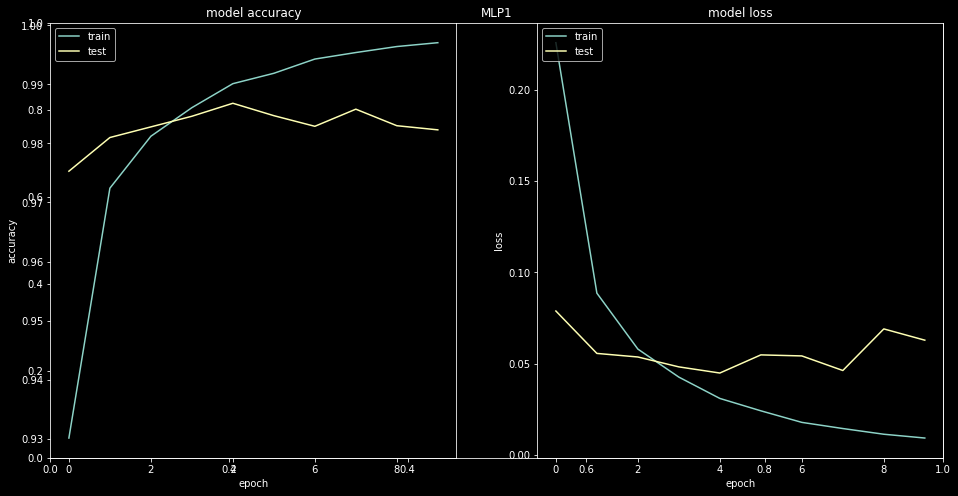

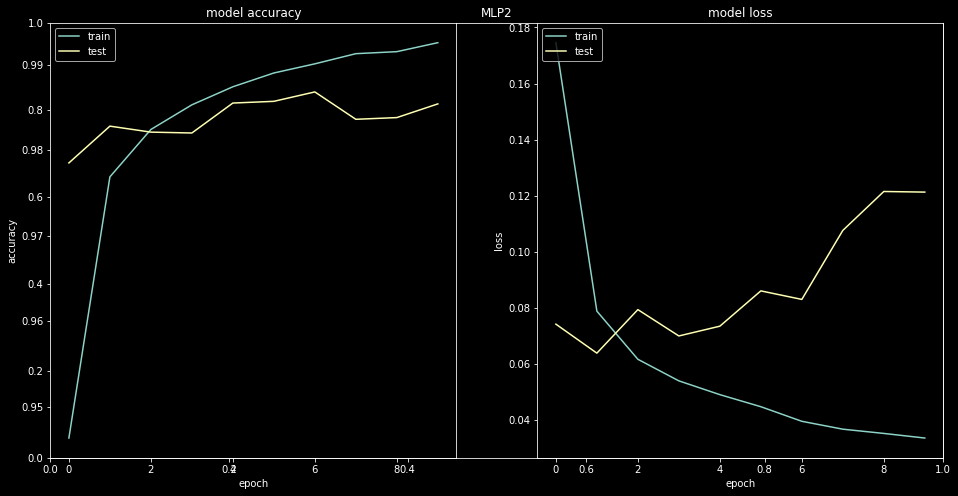

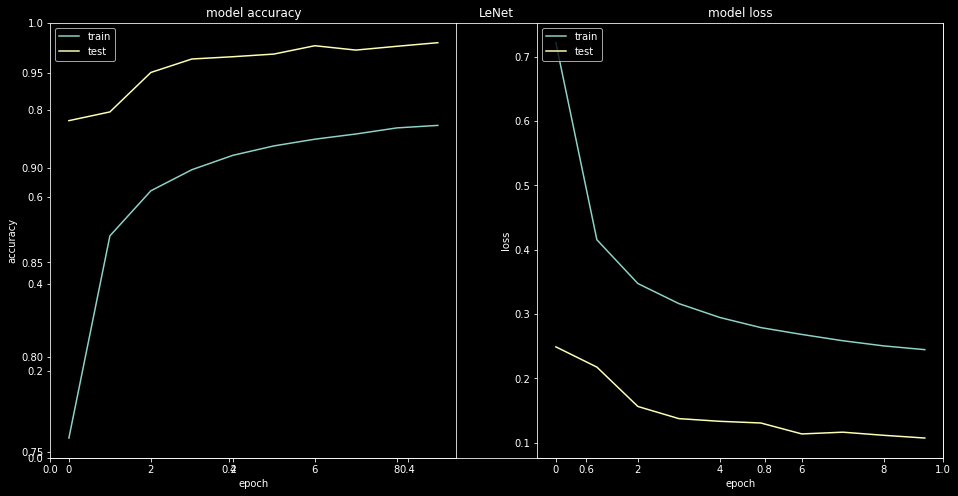

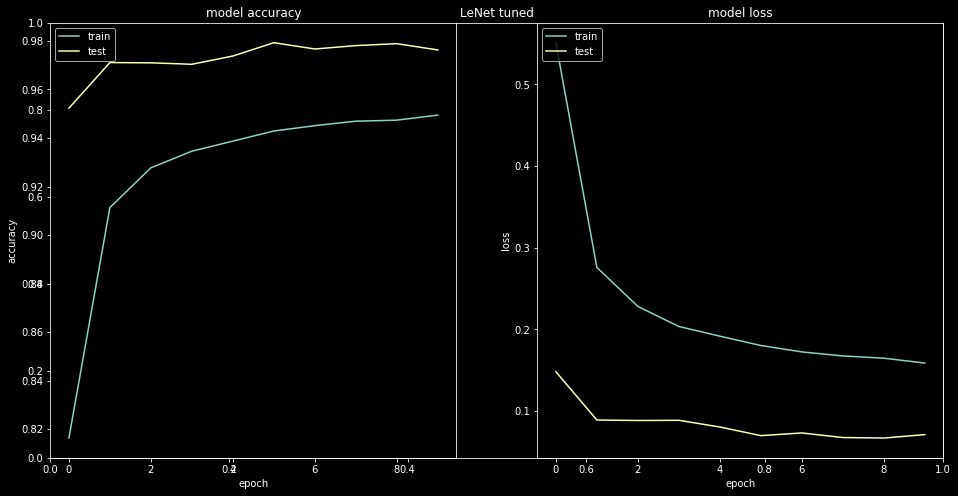

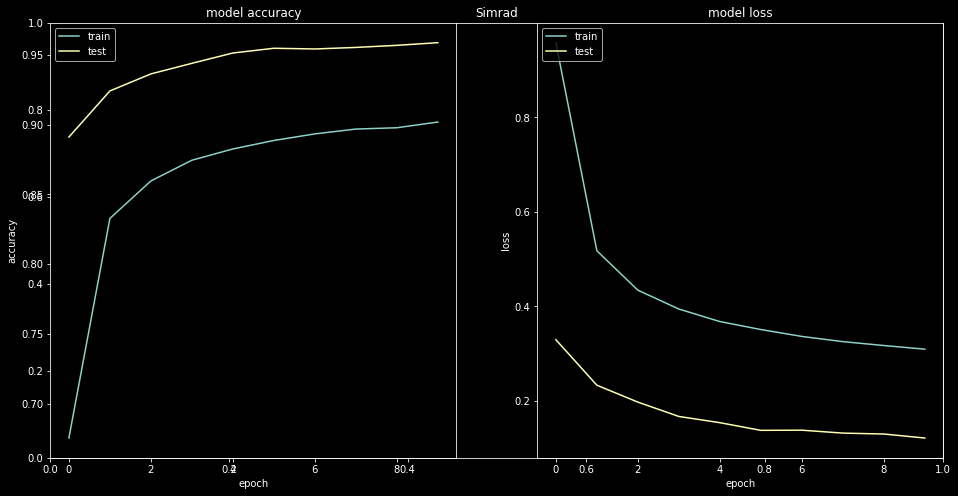

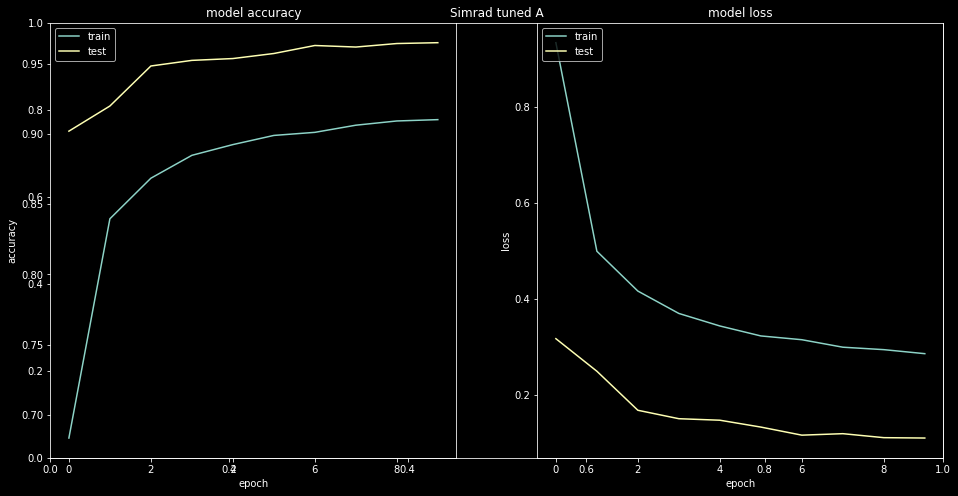

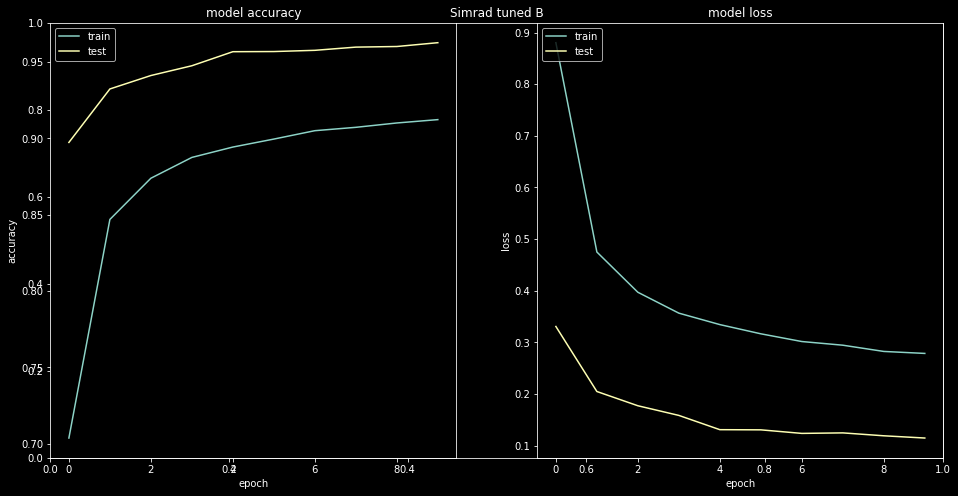

In [17]:
mt.plot_history(history_mp1, 'MLP1')
mt.plot_history(history_mp2, 'MLP2')
mt.plot_history(history_lenet, 'LeNet')
mt.plot_history(history_lenet_tuned, 'LeNet tuned')
mt.plot_history(history_simrad, 'Simrad')
mt.plot_history(history_simrad_tuned_a, 'Simrad tuned A')
mt.plot_history(history_simrad_tuned_b, 'Simrad tuned B')

## Save models

In [18]:
import os
import pathlib
from pathlib import Path
path = pathlib.Path('.')
path = path / 'model_dev_dir'
if not os.path.exists(path):
    path.mkdir()
print(path.resolve())
for m in models:
    k =  path / m
    if not os.path.exists(k):
        k.mkdir()
    md[m].save(str(k / (m + '.h5')))

/home/luismata/ai_tools/python/models_dev/model_dev_dir


## Save data
Too big for uploading to GitHub

In [ ]:
path = pathlib.Path('./model_dev_dir/_data')
if not os.path.exists(path):
    path.mkdir()
# MLPs
k =  path / 'MLPs'
x_train, x_test, x_val, y_train, y_test, y_val = prepare_MLP()
mt.save_data_to_file(k, x_train, y_train, x_test, y_test)
# Lenets
k = path / 'lenets'
x_train, x_test, x_val, y_train, y_test, y_val = prepare_lenet()
mt.save_data_to_file(k, x_train, y_train, x_test, y_test)
# Simrads
k = path / 'simrads'
x_train, x_test, x_val, y_train, y_test, y_val = prepare_simrad()
mt.save_data_to_file(k, x_train, y_train, x_test, y_test)